In [13]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [4]:
#reading the dataset
df= pd.read_csv('JoeBiden_Filtered_TW.csv')
display(df.head(5))

,Unnamed: 0,Filtered
0,0,Not only do Republicans oppose making big corp...
1,1,A stronger economy built from the bottom up an...
2,2,Democrats are working tirelessly to open doors...
3,3,American workers are beginning to rebuild our ...
4,4,This is not your father ’s Republican Party. h...


In [5]:
#chekcing the number of reviews we have
print("Number of reviews - ",df.shape)

Number of reviews -  (145, 2)


In [6]:
df_5000= df[0:5000]

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_5000.Filtered.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['not', 'only', 'do', 'republicans', 'oppose', 'making', 'big', 'corporations', 'pay', 'their', 'fair', 'share', 'they', 'want', 'middle', 'class', 'families', 'and', 'small', 'business', 'owners', 'to', 'pay', 'more', 'in', 'taxes']]


# Build the Bigram, Trigram Models and Lemmatize

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

done


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.029*"cancer" + 0.025*"pay" + 0.024*"call" + 0.017*"cut" + 0.017*"ensure" '
  '+ 0.017*"set" + 0.012*"class" + 0.012*"covid" + 0.012*"pandemic" + '
  '0.012*"middle"'),
 (1,
  '0.048*"build" + 0.032*"job" + 0.032*"cost" + 0.029*"well" + 0.024*"back" + '
  '0.021*"american" + 0.019*"country" + 0.019*"plan" + 0.019*"create" + '
  '0.018*"new"'),
 (2,
  '0.026*"party" + 0.022*"vehicle" + 0.022*"electric" + 0.022*"focus" + '
  '0.017*"help" + 0.015*"support" + 0.015*"price" + 0.014*"investment" + '
  '0.014*"continue" + 0.012*"nation"'),
 (3,
  '0.036*"care" + 0.031*"union" + 0.018*"future" + 0.018*"proud" + 0.017*"let" '
  '+ 0.016*"affordable" + 0.016*"law" + 0.015*"co" + 0.015*"together" + '
  '0.015*"vaccinate"')]


# Dominant topics and its percentage contribution in each document

In [18]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9491,"cancer, pay, call, cut, ensure, set, class, co...","[republican, big, corporation, pay, fair, shar..."
1,1,1.0,0.8509,"build, job, cost, well, back, american, countr...","[strong, economy, build, bottom, middle, put, ..."
2,2,3.0,0.7302,"care, union, future, proud, let, affordable, l...","[work, tirelessly, open, door, outstanding, en..."
3,3,1.0,0.9640,"build, job, cost, well, back, american, countr...","[american, worker, begin, rebuild, nation, roa..."
4,4,3.0,0.6249,"care, union, future, proud, let, affordable, l...",[co]


# The most representative sentence for each topic

In [19]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9623,"cancer, pay, call, cut, ensure, set, class, covid, pandemic, middle","[firefighter, teacher, pay, high, tax, rate, billionaire, pay, budget, contain, billionaire, min..."
1,1.0,0.9640,"build, job, cost, well, back, american, country, plan, create, new","[american, worker, begin, rebuild, nation, road, bridge, port, waterway, create, new, job, moder..."
2,2.0,0.9623,"party, vehicle, electric, focus, help, support, price, investment, continue, nation","[clear, choice, party, focus, future, party, focus, relitigate, past, able, chip, support, elect..."
3,3.0,0.9657,"care, union, future, proud, let, affordable, law, co, together, vaccinate","[international, woman, day, let, recognize, well, future, woman, girl, reach, full, potential, t..."


# Word Clouds of Top N Keywords in Each Topic

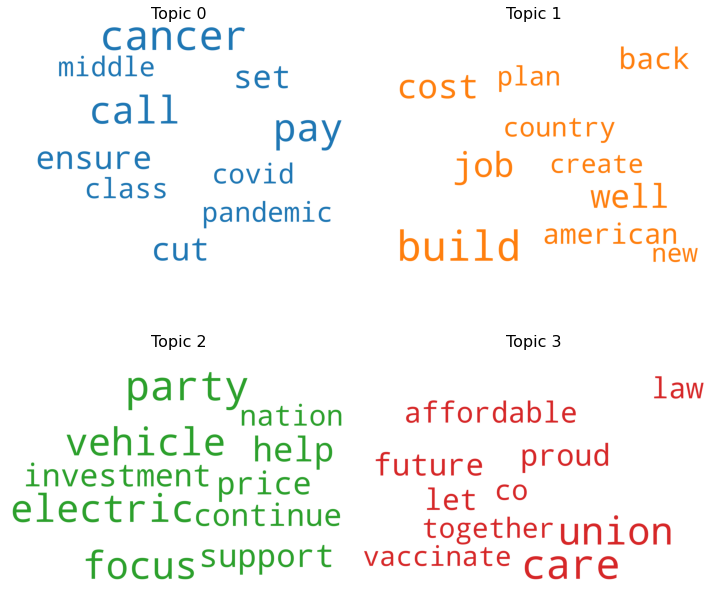

In [21]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
print("done")

# Word Counts of Topic Keywords

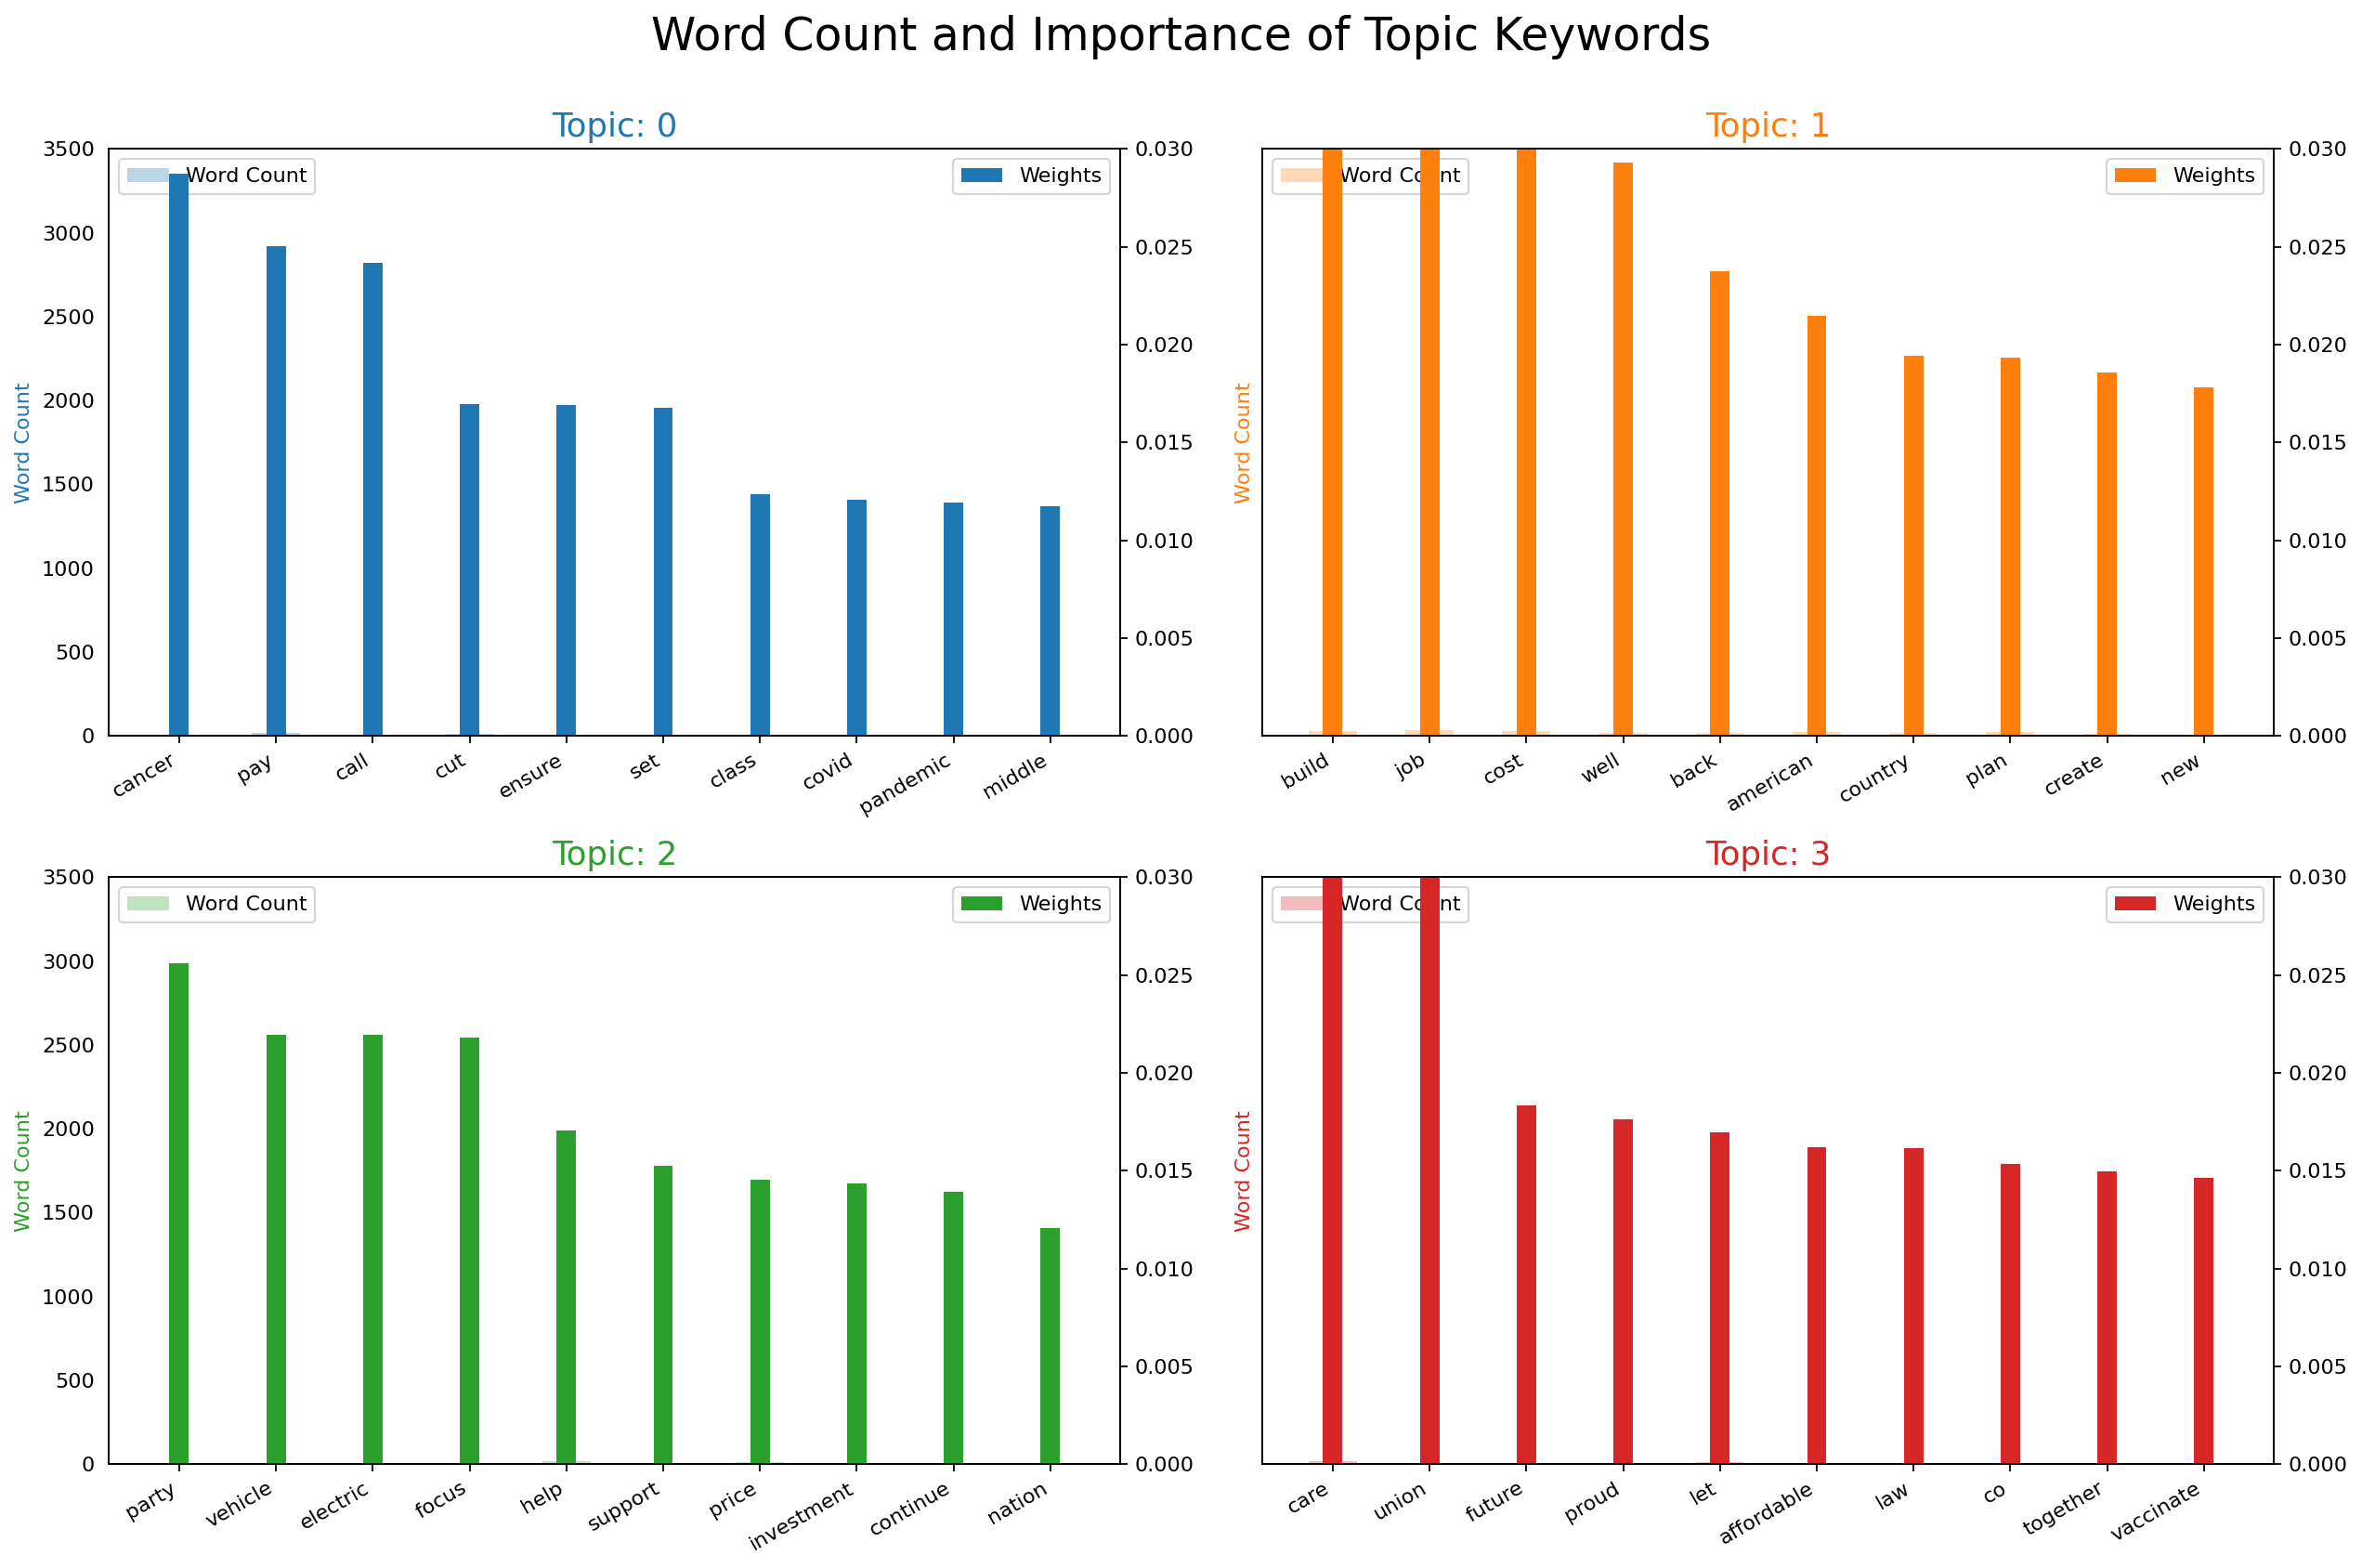

In [22]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Steps to Visualize 

In [26]:
# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.237236 -0.000061       1        1  41.098401
2     -0.091504 -0.144423       2        1  22.085592
3     -0.059676 -0.029085       3        1  19.196525
0     -0.086056  0.173568       4        1  17.619481, topic_info=         Term       Freq      Total Category  logprob  loglift
14      build  39.000000  39.000000  Default  30.0000  30.0000
240      care  14.000000  14.000000  Default  29.0000  29.0000
22        job  26.000000  26.000000  Default  28.0000  28.0000
224      cost  26.000000  26.000000  Default  27.0000  27.0000
303     union  12.000000  12.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
657      lake   3.316061   4.368401   Topic4  -4.6417   1.4605
6      middle   4.033227   5.415155   Topic4  -4.4459   1.4415
8         pay   8.601159  14.175098   Topic4  -3.6885   1.2366
711  organize   3.096780   4.595305   Topic4  -4.7101   1.3415
5      family   3.180900  15.720775   Topic4  -4.6833   0.1383

[175 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
77        2  0.926056            able
238       3  0.960947             act
162       2  0.826360         address
341       4  0.690810  administration
239       3  0.907876      affordable
...     ...       ...             ...
252       3  0.146101            well
428       3  0.949588           woman
43        1  0.974601            work
283       2  0.768839           world
44        3  0.791247            year

[156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])